# Cifar10 上的 ReNet18

本文主要介绍在 cifar10 的试验 resnet18 的性能。

导入一些必要包：

In [1]:
import torch
from torch import nn
from torch.profiler import profile, record_function, ProfilerActivity
from torchvision.models import resnet18, ResNet18_Weights
from torch_book.classifier import Classifier
from torch_book.optim import Trainer
from torch_book.data.simple_vision import Cifar10
torch.cuda.empty_cache() # 清空 GPU 缓存

{mod}`torchvision` 上的 ResNet18 直接用于 cifar10 是不推荐的。需要做以下改动：

```{note}
将 `conv1` 替换以支持 $32 \times 32$ 的输入。同时移除第一个 `maxpool` 避免图片信息过早丢失。
```

In [2]:
class ResNet18(Classifier):
    def __init__(self, plot_train_per_epoch=2,
                 plot_valid_per_epoch=1):
        super().__init__(plot_train_per_epoch=plot_train_per_epoch,
                         plot_valid_per_epoch=plot_valid_per_epoch)
        self.net = self._model()
        
    def _model(self):
        model = resnet18(weights=ResNet18_Weights.DEFAULT)
        model.conv1 = nn.Conv2d(model.conv1.in_channels, 
                                model.conv1.out_channels,
                                3, 1, 1)
        model.maxpool = nn.Identity() # nn.Conv2d(64, 64, 1, 1, 1)
        model.fc = nn.Linear(model.fc.in_features, 10)
        return model

In [3]:
model = ResNet18()

加载数据集：

In [4]:
batch_size = 64
data = Cifar10(batch_size)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


打印每层输出尺寸：

In [5]:
for xs, _ in data.train_dataloader():
    break

for name, m in model.net.named_children():
    xs = m(xs)
    print(name, tuple(xs.shape))
    if name=="avgpool":
        xs = torch.flatten(xs, 1)

conv1 (64, 64, 32, 32)
bn1 (64, 64, 32, 32)
relu (64, 64, 32, 32)
maxpool (64, 64, 32, 32)
layer1 (64, 64, 32, 32)
layer2 (64, 128, 16, 16)
layer3 (64, 256, 8, 8)
layer4 (64, 512, 4, 4)
avgpool (64, 512, 1, 1)
fc (64, 10)


评估此时验证集的精度（由于替换了卷积运算，会造成大量精度损失）：

In [6]:
relu_acc = model.evaluate_accuracy(data.val_dataloader())
relu_acc

0.001559375

微调模型：

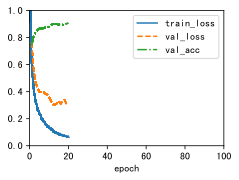

In [7]:
trainer = Trainer(max_epochs=100, num_gpus=1)
model.board.ylim = [0, 1]
trainer.fit(model, data,
            lr=0.00142857,
            momentum=0.857142,
            weight_decay=0.00857142,
            lr_period=2,
            lr_decay=0.857142)

In [ ]:
valid_acc = model.board.data["val_acc"][-1].y
f"valid acc {valid_acc:.3f}"

保存模型：

In [ ]:
torch.save(model.state_dict(),
           'models/resnet18_cifar10_relu_32.h5')

## 性能度量

In [ ]:
inputs = torch.randn(5, 3, 32, 32).type(torch.float32).cuda()
        
with profile(activities=[ProfilerActivity.CPU, 
                         ProfilerActivity.CUDA], 
             record_shapes=True) as prof:
    with record_function("model_inference"):
        model(inputs)
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))